In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import time
import random
import pandas as pd

from scipy import signal
from scipy import misc
from scipy.spatial import distance
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon

from ipywidgets import Image
from ipycanvas import Canvas

### Load image

##### Insert white border around image

In [2]:
edged = cv2.imread("aout.png", cv2.IMREAD_GRAYSCALE);

In [3]:
def showimage(img):
    figure(num=None, figsize=(24, 36), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img)
    plt.show()


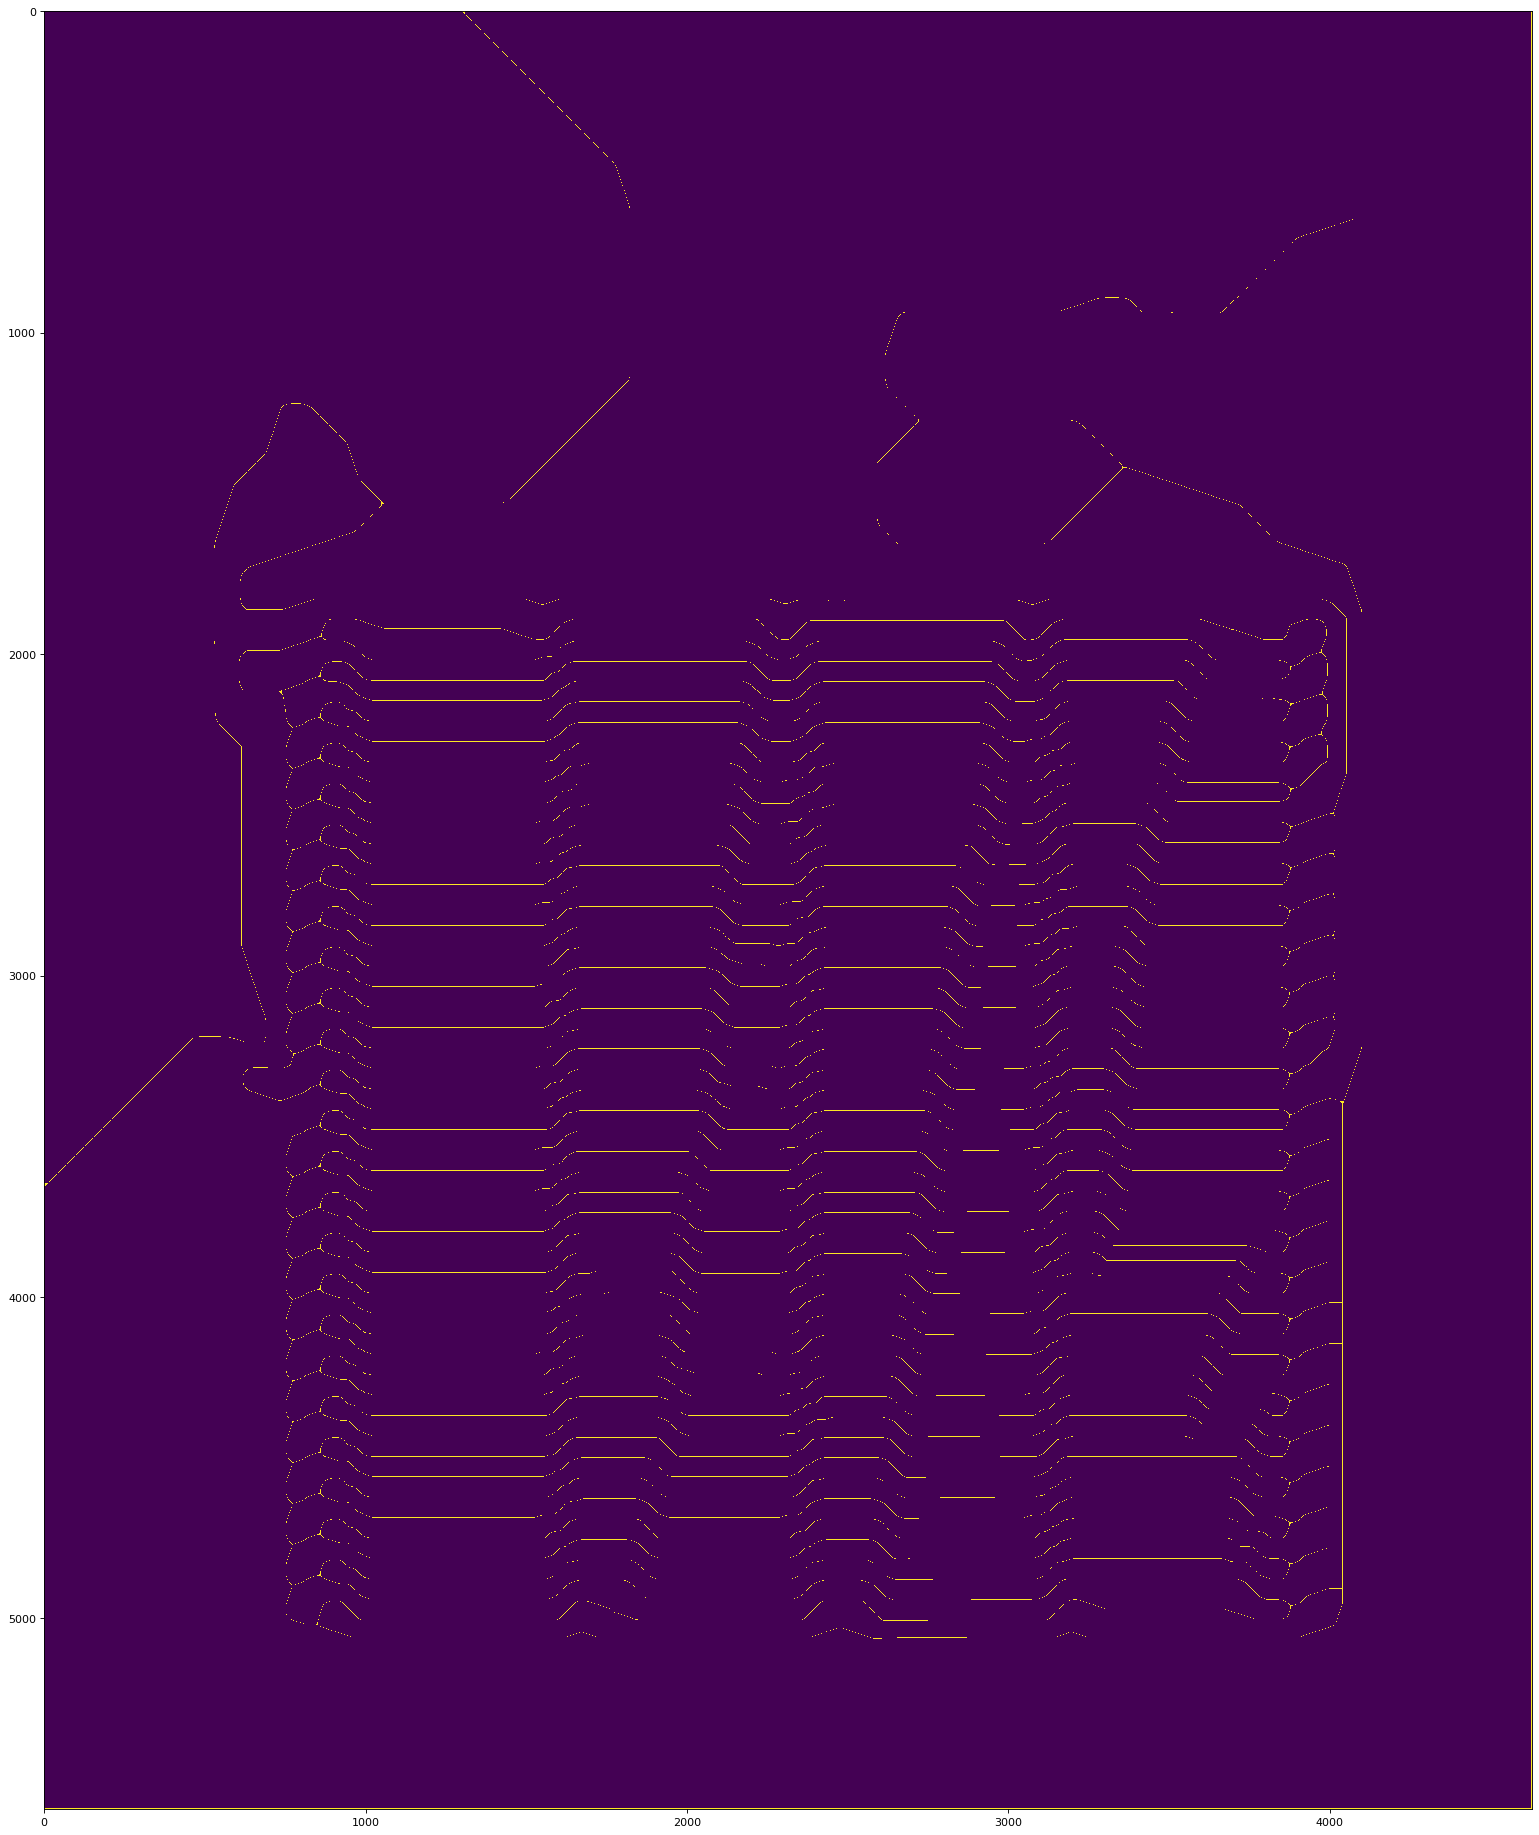

In [4]:
showimage(edged)

### Find Contours from edge Bitmap

In [5]:
contours = find_contours(edged, 240,fully_connected='high',positive_orientation='low')

## Vectorise
- Simplify contours
- Create list with end co-ordinates of lines, gradient, y-axis intercept and length

In [6]:
show_image=False

if show_image:
    figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k');
    
lines = []
for n, contour in enumerate(contours):
    newcontour = approximate_polygon(contour,1)
    
    c = np.expand_dims(newcontour.astype(np.float32), 1)
    c = cv2.UMat(c)
    area = int(cv2.contourArea(c))
    
    lencnt = len(newcontour)    
    [fy,fx] = newcontour[0]
    for i in range(1,lencnt):
        [y,x] = newcontour[i]
        
        length = ((x-fx)**2+(y-fy)**2)**0.5

        #lines.append([int(x),int(y),int(fx),int(fy)])
        if fx!=x:
            m = (fy-y)/(fx-x)
            angle=np.arctan(m)
            cut = y - m*x
        else:
            angle=np.pi/2
            cut = x
        
        lines.append([x,y,fx,fy,angle,cut,length])
        (fx,fy)=(x,y)
    
    if show_image:
        plt.plot(newcontour[:,1],newcontour[:,0])
if show_image:
    plt.show()

### Remove duplicate Vectors
Maintain the longest of vectors

In [7]:
lines_left = lines.copy()
for i in lines:
    [ax1,ay1,ax2,ay2,ag1,ac1,ll1] = i
    lines_left.remove(i)
    for j in lines_left:
        [bx1,by1,bx2,by2,bg1,bc1,ll2] = j
        
        if abs(ag1-bg1)<0.2:
            do_remove=False
            
            if abs(ax1-bx1)<min(ll1,ll2)/2 and abs(ay1-by1)<min(ll1,ll2)/2:
                if abs(ax2-bx2)<10 and abs(ay2-by2)<10:
                    do_remove=True
                
            if abs(ax1-bx2)<10 and abs(ay1-by2)<10:
                if abs(ax2-bx1)<10 and abs(ay2-by1)<10:
                    do_remove=True
            
            if do_remove==True:
                
                if ll1>ll2:  ## take out the smallest of the lines
                    if j in lines:
                        lines.remove(j)
                else:
                    if i in lines:
                        lines.remove(i)

### List all the Vertices in an array

In [8]:
if show_image:
    figure(num=None, figsize=(24, 16), dpi=80, facecolor='w', edgecolor='k');            

epsilon = 4

newpoints = []
newlines = []
for i in lines:
    [ax1,ay1,ax2,ay2,ag1,ac1,ll1] = i  ##LINE1
    
    
    restline = lines.copy()
    restline.remove(i)
    
    plotit=0
    
    ## Find 
    for j in restline:
        [bx1,by1,bx2,by2,bg1,bc1,ll2] = j ##LINE2
        
        
        if abs(bx1-ax1)<epsilon and abs(by1-ay1)<epsilon:
            if show_image:
                plt.plot(ax1,ay1,'bo')
            plotit=plotit+1
            
        if abs(bx1-ax2)<epsilon and abs(by1-ay2)<epsilon:
            if show_image:
                plt.plot(ax2,ay2,'bo')
            plotit=plotit+1
            
        if abs(bx2-ax1)<epsilon and abs(by2-ay1)<epsilon:
            if show_image:
                plt.plot(ax1,ay1,'bo')
            plotit=plotit+1
            
        if abs(bx2-ax2)<epsilon and abs(by2-ay2)<epsilon:
            if show_image:
                plt.plot(ax2,ay2,'bo')
            plotit=plotit+1
            
    newpoints.append([ax1,ay1])
    newpoints.append([ax2,ay2])
    
    ##Cleanup lines rules
    if plotit == 0:  ## Standalone lines with length<5 are eliminated
        if ll1>5:
            newlines.append([ax1,ay1,ax2,ay2])
            if show_image:
                plt.plot((ax1,ax2),(ay1,ay2),'r-')
                
    elif plotit == 1:  ## Lines with zero length removed if Two lines joined at one vertex 
        if ll1>0:
            newlines.append([ax1,ay1,ax2,ay2])
            if show_image:
                plt.plot((ax1,ax2),(ay1,ay2),'g-')
    else: ## Many lines joined at the same vertex are maintained
        newlines.append([ax1,ay1,ax2,ay2])
        if show_image:
            plt.plot((ax1,ax2),(ay1,ay2),'b-')
    
            
if show_image:
    plt.show()

X=np.array(newpoints)

In [9]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

## Cluster close vertices with 8 pixel radius - Minimum sample 1

In [10]:
db = DBSCAN(eps=8, min_samples=1).fit(X)

In [11]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print('Original Points: %d' % len(newpoints))

Estimated number of clusters: 2807
Original Points: 7450


### Vertex Group clusters
Calculate centroids of the clusters

In [12]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
centroids = []
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]

    sx=0
    sy=0
    for [x,y] in xy:
        sx=sx+x
        sy=sy+y
        #plt.text(x, y , str(k), **style)
    
    sx=sx/len(xy)
    sy=sy/len(xy)
    centroids.append([sx,sy])  # Centroids
    
    xy = X[class_member_mask & ~core_samples_mask]

Clustered Vertices are replaced by their centroids

In [13]:
cen_line_list=[]
for j in newlines: ## redraw lines
    [x1,y1,x2,y2] = j
    
    label1 = [t for (t,[xx,yy]) in enumerate(newpoints) if xx==x1 and yy==y1]  ## get centroid index of point1
    label2 = [t for (t,[xx,yy]) in enumerate(newpoints) if xx==x2 and yy==y2]  ## get centroid index of point2
    
    index1 = labels[label1[0]]
    index2 = labels[label2[0]]
    
    [xx1,yy1]=centroids[index1] ## get coord of centroid 1
    [xx2,yy2]=centroids[index2] ## get coord of centroid 2
    
    cen_line_list.append([xx1,yy1,xx2,yy2]) # create a new list of line using centroids


In [14]:
if show_image:
    imagedata_compare = np.zeros_like(edged) 
    
    for j in cen_line_list:
        [xx1,yy1,xx2,yy2]=j
        cv2magedata_compare = cv2.line(imagedata_compare, (int(xx1),int(yy1)), (int(xx2),int(yy2)), (255,0,0), 2)
        

    showimage(imagedata_compare)

###  Shortest Path Algorithm
```Pickup path p1 from list

Do while there are paths in the list
    Remove path p1 from list
    Pickup vertex v1 from end-points of path p1
    Select next path as new p1 - with one of its vertices closest to v1
    Select other vertex from latest path as new v1```


In [32]:
cen_line_list=bck.copy()

In [33]:
p1=0
ordered_list=[]
[xx1,yy1,xx2,yy2]=cen_line_list[p1]
v1=(int(xx1),int(yy1))

while len(cen_line_list)>0:
    
    ### select next vertex (the one different from the current v1 vertex)
    [xx1,yy1,xx2,yy2]=cen_line_list[p1]
    vn1=(int(xx1),int(yy1))
    vn2=(int(xx2),int(yy2))
    if v1==vn1:
        ordered_list.append([v1,vn2])
        v1=vn2
    else:
        ordered_list.append([v1,vn1])
        v1=vn1
        
    ### remove lines from old list
    del cen_line_list[p1]
    
    mindis = 999999999
    new_p1 = -1
    new_v1 = -1
    jump = True ### when we find no zero co-ordinate then we have to switch off lasers and move
    
    for p1,j in enumerate(cen_line_list):
        a = (int(j[0]),int(j[1]))
        b = (int(j[2]),int(j[3]))
        
        ### calculate manhattan distance between p1 and one of the vertices of the line
        ### if zero than we found the next line
        ### if not take line with closest vertices
        dis = sum(tuple(abs(x-y) for x,y in zip(v1,a)))
        
        if dis<mindis:
            mindis=dis
            new_p1=p1
            new_v1=a
            
        dis = sum(tuple(abs(x-y) for x,y in zip(v1,b)))
        
        if dis<mindis:
            mindis=dis
            new_p1=p1
            new_v1=b
            
        if mindis==0: ## No one closer than \ zero distance
            jump=False
            break
    
    v1 = new_v1
    p1 = new_p1
    
    if jump:
        ordered_list.append([(-1,-1),(-1,-1)])
    
        
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


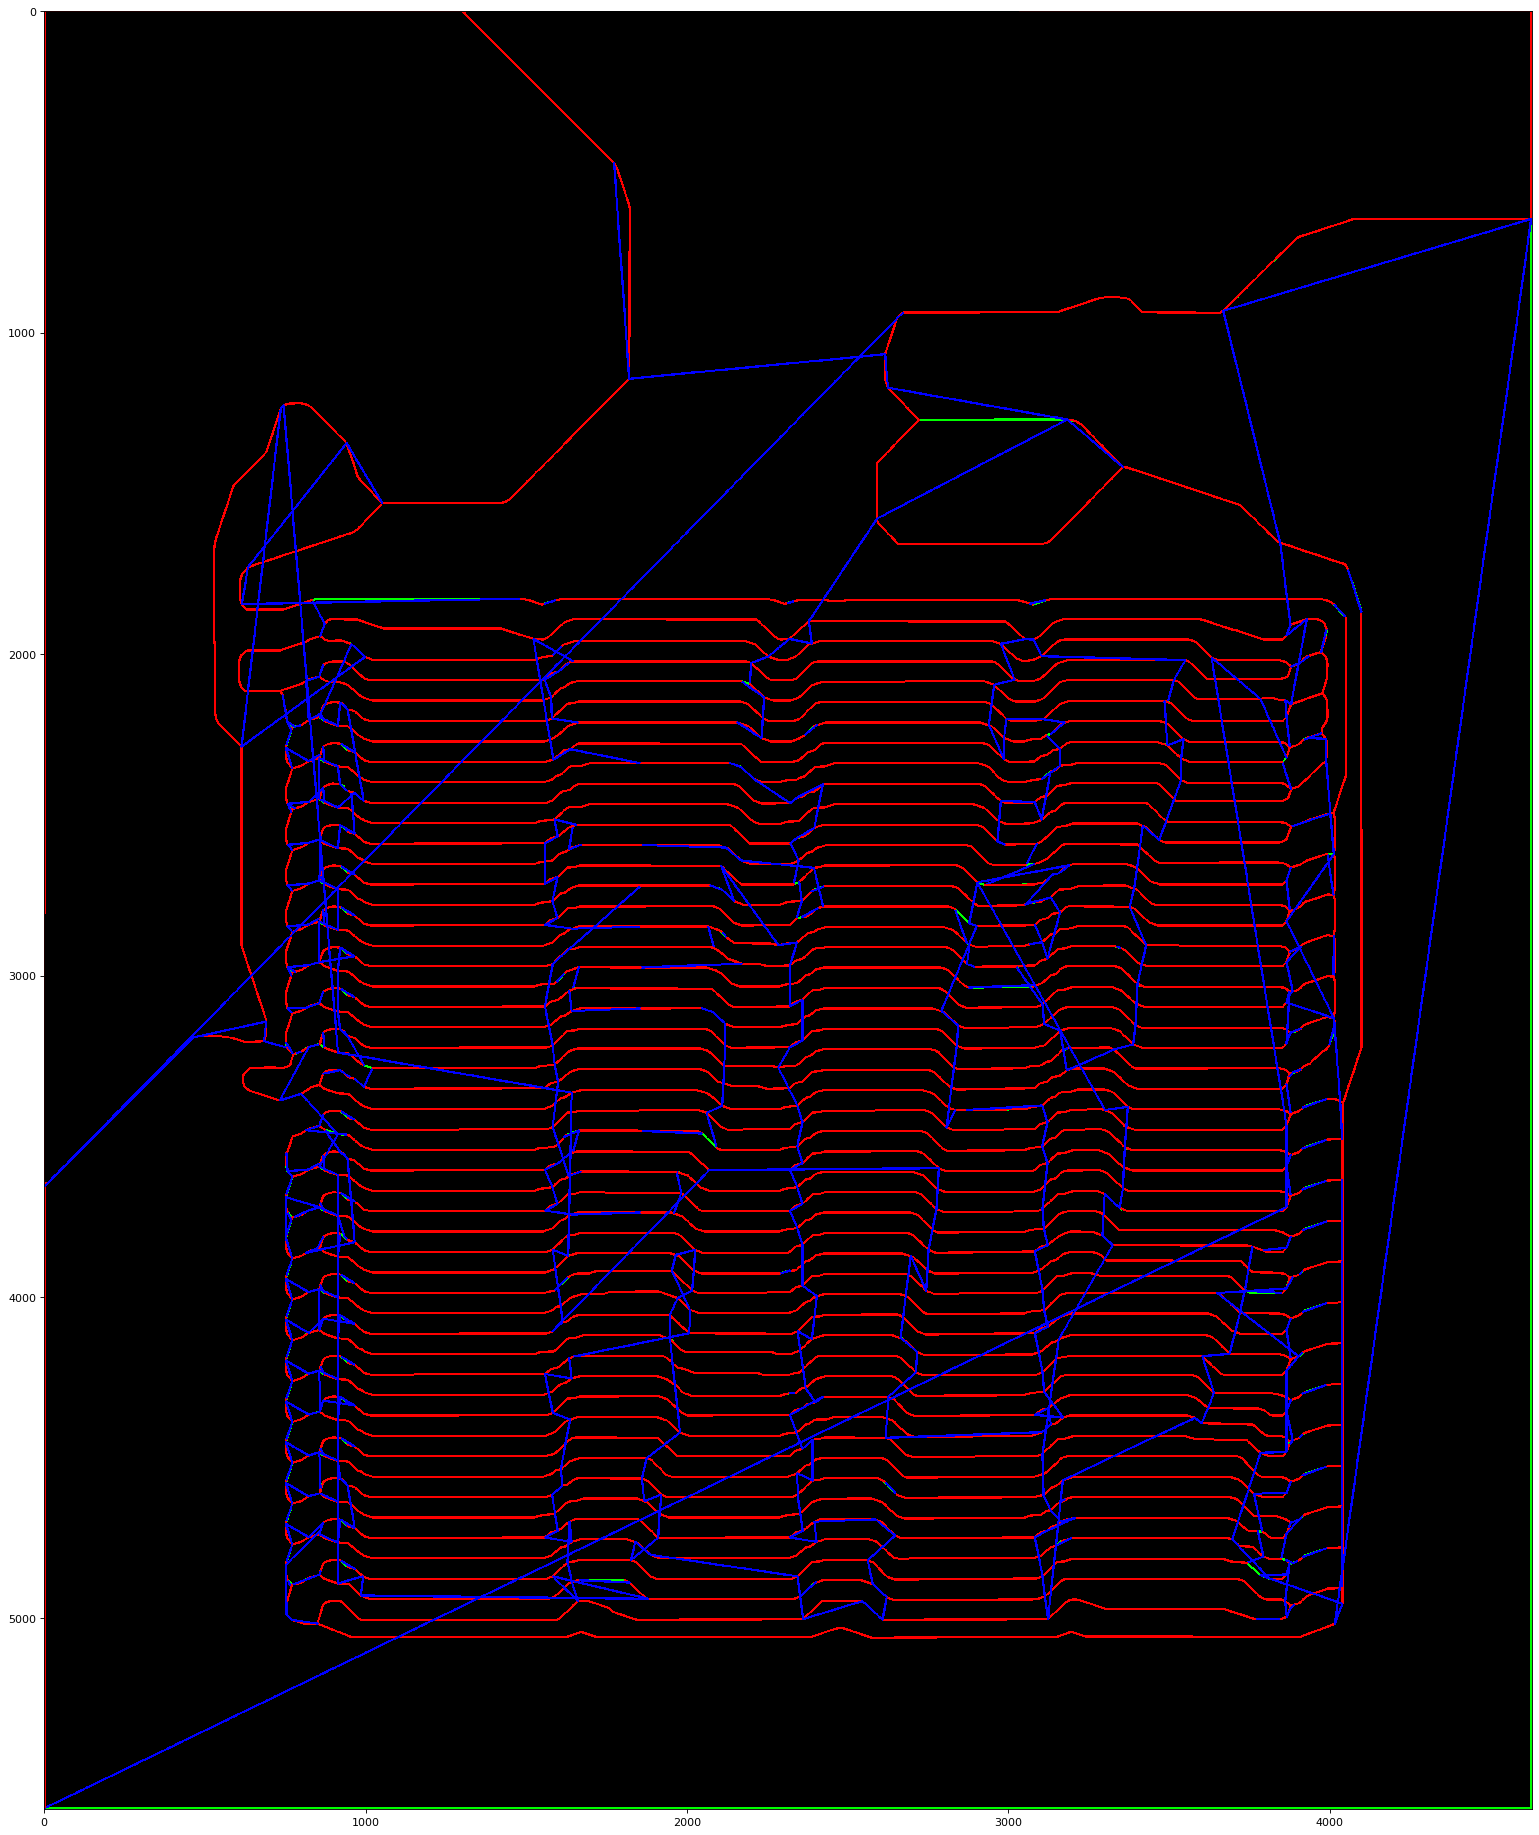

In [36]:
show_image=True
next_color=(255,0,0)
if show_image:
    (sx,sy)=edged.shape
    imagedata_compare = np.zeros((sx,sy,3))
    
    vs=ordered_list[0]
    vt1=vs[0]
    v1=(int(vt1[0]),int(vt1[1]))
    for j in ordered_list:
        imagedata_compare = cv2.line(imagedata_compare, j[0], j[1], (0,255,0), 5)
    
    
    for j in ordered_list:
        vt1=j[1]
        v2=(int(vt1[0]),int(vt1[1]))
        
        if v2==(-1,-1):
            next_color=(0,0,255)
        else:
            imagedata_compare = cv2.line(imagedata_compare, v1, v2, next_color, 5)
            next_color=(255,0,0)        
            v1=v2
    
        

    showimage(imagedata_compare)

In [31]:
ordered_list

[[(466, 3194), (466, 3194)],
 [(-1, -1), (-1, -1)],
 [(466.5, 3194.75), (466, 3194)],
 [(-1, -1), (-1, -1)],
 [(466.5, 3194.75), (2, 3656)],
 [(-1, -1), (-1, -1)],
 [(2.0294117647058822, 3656.529411764706), (2, 3656)],
 [(-1, -1), (-1, -1)],
 [(2.0294117647058822, 3656.529411764706), (1, 5591)],
 [(-1, -1), (-1, -1)],
 [(1.0588235294117647, 5591.0), (4626, 5591)],
 [(-1, -1), (-1, -1)],
 [(4626.941176470588, 5591.0), (4626, 649)],
 [(-1, -1), (-1, -1)],
 [(4626.627450980392, 649.6470588235294), (4625, 1)],
 [(-1, -1), (-1, -1)],
 [(4625.470588235294, 1.0294117647058822), (4625, 1)],
 [(-1, -1), (-1, -1)],
 [(4625.470588235294, 1.0294117647058822), (1309, 0)],
 [(-1, -1), (-1, -1)],
 [(1309.0, 0.058823529411764705), (1308, 11)],
 [(-1, -1), (-1, -1)],
 [(1308.0588235294117, 11.0), (1773, 476)],
 [(-1, -1), (-1, -1)],
 [(1773.3529411764705, 476.6666666666667), (1298, 1)],
 [(-1, -1), (-1, -1)],
 [(1298.0, 1.0588235294117647), (2, 2)],
 [(-1, -1), (-1, -1)],
 [(2.0294117647058822, 2.02941